# Conversion Analysis on Web Design

## 1. Introduction
In this project, I will be analyzing the results of an A/B test run by an e-commerce website.  The final goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision

## 2. Import data & data cleaning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt

%matplotlib inline

In [3]:
df=pd.read_excel('sample ab_data.xlsx')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104.0,11:48.6,control,old_page,0.0
1,804228.0,01:45.2,control,old_page,0.0
2,661590.0,55:06.2,treatment,new_page,1.0
3,853541.0,28:03.1,treatment,new_page,1.0
4,864975.0,52:26.2,control,old_page,1.0


Get an overview of the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       294478 non-null  float64
 1   timestamp     294478 non-null  object 
 2   group         294478 non-null  object 
 3   landing_page  294478 non-null  object 
 4   converted     294478 non-null  float64
dtypes: float64(2), object(3)
memory usage: 11.2+ MB


Check if `group` aligns with `landing_page`

In [5]:
((df.group=='treatment') & (df.landing_page=='old_page')).sum()

1965

In [6]:
((df.group=='control') & (df.landing_page=='new_page')).sum()

1928

In [7]:
df['misaligned']=((df.group=='treatment') & (df.landing_page=='old_page')) | ((df.group=='control') & (df.landing_page=='new_page'))
df = df[-df['misaligned']]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   user_id       290585 non-null  float64
 1   timestamp     290585 non-null  object 
 2   group         290585 non-null  object 
 3   landing_page  290585 non-null  object 
 4   converted     290585 non-null  float64
 5   misaligned    290585 non-null  bool   
dtypes: bool(1), float64(2), object(3)
memory usage: 13.6+ MB


Check unique users

In [9]:
df.user_id.nunique()

290584

In [10]:
df['user_id'].value_counts().sort_values(ascending=False).head()

773192.0    2
834487.0    1
936923.0    1
679687.0    1
719014.0    1
Name: user_id, dtype: int64

In [11]:
df[df['user_id']==773192]

,user_id,timestamp,group,landing_page,converted,misaligned
1899,773192.0,37:58.8,treatment,new_page,1.0,False
2893,773192.0,55:59.6,treatment,new_page,0.0,False


In [12]:
df.drop(1899, axis = 0,inplace = True) #based on assumption

In [13]:
df['user_id'].value_counts().sort_values(ascending=False).head()

851104.0    1
834487.0    1
936923.0    1
679687.0    1
719014.0    1
Name: user_id, dtype: int64

How many users in each group

In [14]:
df[['user_id','group']].groupby('group').count()

,user_id
group,
control,145274
treatment,145310


Conversion rate in each group

In [15]:
df[['user_id','group','converted']].groupby('group').agg({'user_id':'count','converted':'mean'})

,user_id,converted
group,,
control,145274,0.120386
treatment,145310,0.125353


### EDA

In [16]:
df.head(10)

,user_id,timestamp,group,landing_page,converted,misaligned
0,851104.0,11:48.6,control,old_page,0.0,False
1,804228.0,01:45.2,control,old_page,0.0,False
2,661590.0,55:06.2,treatment,new_page,1.0,False
3,853541.0,28:03.1,treatment,new_page,1.0,False
4,864975.0,52:26.2,control,old_page,1.0,False
5,936923.0,20:49.1,control,old_page,0.0,False
6,679687.0,26:46.9,treatment,new_page,1.0,False
7,719014.0,48:29.5,control,old_page,0.0,False
8,817355.0,58:09.0,treatment,new_page,1.0,False
9,839785.0,11:06.6,treatment,new_page,1.0,False


In [17]:
# line: overall trends
# line: trends over different time / group

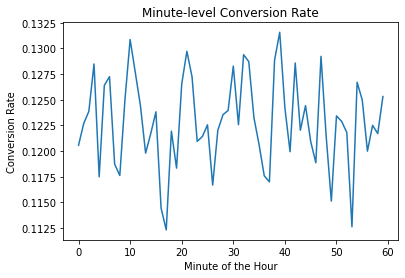

In [18]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%M:%S.%f')
df['minute'] = df['timestamp'].dt.minute
df.set_index('timestamp', inplace=True)

minute_conversion = df.groupby('minute')['converted'].mean()
plt.plot(minute_conversion.index, minute_conversion.values)
plt.xlabel('Minute of the Hour')
plt.ylabel('Conversion Rate')
plt.title('Minute-level Conversion Rate')
plt.show()

In [19]:
minute_conversion = df.groupby('minute')['converted'].mean().reset_index()
# Create the Altair chart
chart = alt.Chart(minute_conversion).mark_line().encode(
    x=alt.X('minute', title='Minute of the Hour'),
    y=alt.Y('converted', scale=alt.Scale(domain=[0.1, 0.15]), title='Conversion Rate')
).properties(
    width=600,
    height=400,
    title='Minute-level Conversion Rate'
)

# Customize axis labels and title
chart = chart.configure_axis(
    labelFontSize=12,    # Font size for axis labels
    titleFontSize=14     # Font size for axis titles
).configure_title(
    fontSize=16          # Font size for the chart title
)

# Display the Altair chart
chart

alt.Chart(...)

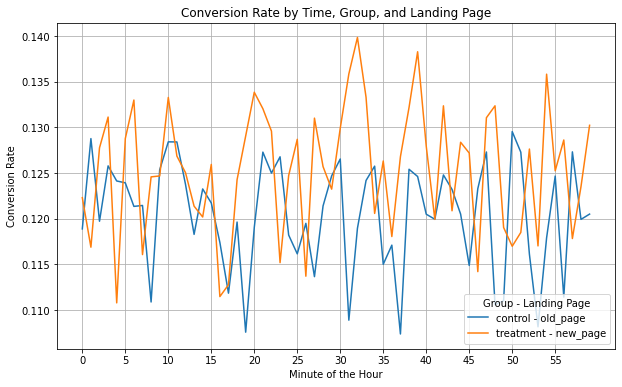

In [20]:
# Group by 'minute', 'group', and 'landing_page' and calculate conversion rate
grouped_data = df.groupby(['minute', 'group', 'landing_page'])
conversion_rate_by_time_group_lp = grouped_data['converted'].mean().reset_index()

# Plot the conversion rate over time for each group and landing page combination
plt.figure(figsize=(10, 6))

for group_name, group_data in conversion_rate_by_time_group_lp.groupby('group'):
    for landing_page_name, landing_page_data in group_data.groupby('landing_page'):
        label = f"{group_name} - {landing_page_name}"
        plt.plot(landing_page_data['minute'], landing_page_data['converted'], label=label)

plt.xlabel('Minute of the Hour')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Time, Group, and Landing Page')
plt.legend(title='Group - Landing Page', loc='lower right')
plt.xticks(range(0, 60, 5))  # Customize the x-axis ticks for better visibility
plt.grid(True)  # Add gridlines for better readability
plt.show()

In [21]:
# Create Altair chart
chart = alt.Chart(conversion_rate_by_time_group_lp).mark_line().encode(
    x=alt.X('minute', title='Minute of the Hour'),
    y=alt.Y('converted', scale=alt.Scale(domain=[0.1, 0.15]), title='Conversion Rate'),
    color='group:N',
    strokeDash='landing_page:N',
    tooltip=['group', 'landing_page', 'minute', 'converted']
).properties(
    width=600,
    height=400,
    title='Conversion Rate by Time, Group, and Landing Page'
)

# Convert the chart to a dictionary
chart_dict = chart.to_dict()

# Create a new static chart from the dictionary representation
static_chart = alt.Chart.from_dict(chart_dict)

# Display the static chart
static_chart

alt.Chart(...)

In [22]:
# bar: distribution

In [23]:
# Group by 'group' and calculate the conversion counts
group_conversion_counts = df.groupby('group')['converted'].sum().reset_index()

# Create the Altair bar chart
chart = alt.Chart(group_conversion_counts).mark_bar().encode(
    x=alt.X('group:N', axis=alt.Axis(labelAngle=0)),
    y='converted:Q'
).properties(
    width=400,
    height=300,
    title='Conversion Counts by Group'
)

# Customize axis labels and title
chart = chart.configure_axis(
    labelFontSize=12,    # Font size for axis labels
    titleFontSize=14     # Font size for axis titles
).configure_title(
    fontSize=16          # Font size for the chart title
)

# Display the Altair chart
chart

alt.Chart(...)

In [24]:
# Group by 'group' and calculate the conversion counts and conversion rates
group_conversion_counts = df.groupby('group')['converted'].sum().reset_index()
group_conversion_rates = df.groupby('group')['converted'].mean().reset_index()
group_conversion_counts['conversion_rate'] = group_conversion_rates['converted']

# Create the Altair bar chart for conversion counts by group
bar_chart = alt.Chart(group_conversion_counts).mark_bar().encode(
    x=alt.X('group:N', axis=alt.Axis(labelAngle=0)),
    y='converted:Q'
).properties(
    width=400,
    height=300,
    title='Conversion Counts by Group'
)

# Create the Altair text chart for conversion rates at the top of each bar
text_chart = alt.Chart(group_conversion_counts).mark_text(
    align='center',
    baseline='middle',
    dy=-10  # Adjust vertical position of the text labels
).encode(
    x=alt.X('group:N'),
    y=alt.Y('converted:Q'),
    text=alt.Text('conversion_rate:Q', format='.1%')  # Display conversion rate with one decimal place
)

# Combine the bar chart and text chart using layering
final_chart = bar_chart + text_chart

# Customize axis labels and title
final_chart = final_chart.configure_axis(
    labelFontSize=12,    # Font size for axis labels
    titleFontSize=14     # Font size for axis titles
).configure_title(
    fontSize=16          # Font size for the chart title
)

# Display the final Altair chart
final_chart


alt.LayerChart(...)

## 3. Analyze results

Let's assume that the new page does not have higher conversion rate than the old page at 5% Type I error. So the hypothesis woule be:

**null:** **$p_{new}$** - **$p_{old}$** <=0

**alternative:** **$p_{new}$** - **$p_{old}$** >0

In [25]:
convert_old = df[df.group=='control'].converted.sum()
convert_new = df[df.group=='treatment'].converted.sum()
n_old = len(df[df.group=='control'].converted)
n_new= len(df[df.group=='treatment'].converted)

convert_old, convert_new, n_old, n_new

(17489.0, 18215.0, 145274, 145310)

In [26]:
conversion_dic = {'Views':{'Control':n_old,'Test':n_new},'Converts': {'Control':convert_old,'Test':convert_new}}
conversion_table = pd.DataFrame(conversion_dic)
conversion_table['Conversion %'] = conversion_table['Converts'] / conversion_table['Views']
conversion_table['Conversion %'] = conversion_table['Conversion %'].apply(lambda x: str(np.round(x,3)*100)+'%')
conversion_table

,Views,Converts,Conversion %
Control,145274,17489.0,12.0%
Test,145310,18215.0,12.5%


### 3.1 Z-test in our way

In [27]:
def z_test(p1,p0,n1,n0):
    delta = p1-p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta / np.sqrt(p*(1-p)*(1/n1 + 1/n0))

#binomial, sample size > 30 -> central limit -> normal

In [28]:
p1 = convert_new / n_new
p0 = convert_old / n_old
n1 = n_new
n0 = n_old

In [29]:
z_value = z_test(p1,p0,n1,n0)
z_value

4.077481782861739

In [30]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)

p_value

2.276304781123617e-05

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page

### 3.2 Z-test in Statsmodels

In [31]:
import statsmodels.api as sm

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(4.077481782861739, 2.276304781118429e-05)

p-value is less than 0.05, so we can reject null hypothesis and accept alternative hypothesis that
<br>**$p_{new}$** - **$p_{old}$** >0, the new page has higher conversion rate than the old page